# Implementing an Autoencoder in PyTorch

### Setup

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

## Set our seed and other configurations for reproducibility.

In [6]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### We set the batch size, the number of training epochs, and the learning rate.

In [7]:
batch_size = 64
epochs = 20
learning_rate = 1e-3

### Dataset

##### We load our MNIST dataset using the torchvision package.

In [17]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [18]:
examples = iter(train_loader)
example_data, example_targets = next(examples)
print(example_data.shape)
print(example_targets)

torch.Size([64, 1, 28, 28])
tensor([5, 0, 4, 9, 9, 9, 3, 9, 0, 4, 7, 4, 9, 6, 6, 1, 3, 6, 1, 3, 5, 5, 8, 7,
        6, 4, 7, 4, 3, 8, 2, 5, 9, 3, 5, 7, 2, 2, 8, 1, 7, 0, 2, 0, 6, 8, 8, 9,
        7, 2, 6, 3, 6, 1, 4, 1, 1, 7, 0, 7, 9, 2, 9, 8])


In [19]:
dataiter = iter(train_loader)
images,labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


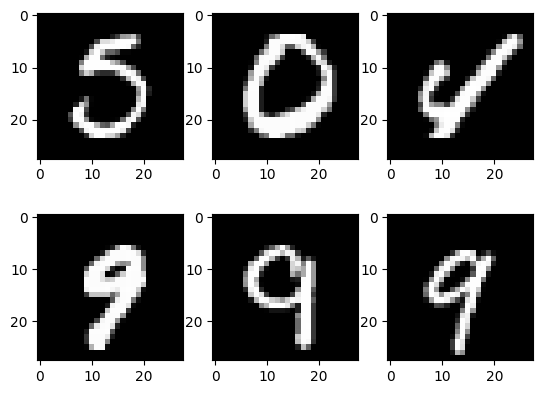

In [20]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

# Using sigmoid as activation function of the output layer

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=64
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=64, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        out1 = self.encoder_hidden_layer(features)
        activation = torch.relu(out1)
        out2 = self.encoder_output_layer(activation)
        activation1 = torch.sigmoid(out2)
        out3 = self.decoder_hidden_layer(activation1)
        activation2 = torch.relu(out3)
        out4 = self.decoder_output_layer(activation2)
        reconstructed = torch.sigmoid(out4)
        return reconstructed

# MSE used as metric

Before using our defined autoencoder class, we have the following things to do: 1. We configure which device we want to run on. 2. We instantiate an AE object. 3. We define our optimizer. 4. We define our reconstruction loss.

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

We train our autoencoder for our specified number of epochs.

In [ ]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.06020244
epoch : 2/20, recon loss = 0.03913211
epoch : 3/20, recon loss = 0.03072785
epoch : 4/20, recon loss = 0.02478984
epoch : 5/20, recon loss = 0.02163216
epoch : 6/20, recon loss = 0.01861697
epoch : 7/20, recon loss = 0.01682523
epoch : 8/20, recon loss = 0.01560544
epoch : 9/20, recon loss = 0.01461803
epoch : 10/20, recon loss = 0.01360464
epoch : 11/20, recon loss = 0.01271752
epoch : 12/20, recon loss = 0.01196072
epoch : 13/20, recon loss = 0.01128641
epoch : 14/20, recon loss = 0.01076208
epoch : 15/20, recon loss = 0.01033419
epoch : 16/20, recon loss = 0.00999095
epoch : 17/20, recon loss = 0.00969997
epoch : 18/20, recon loss = 0.00943304
epoch : 19/20, recon loss = 0.00920858
epoch : 20/20, recon loss = 0.00900470


Let's extract some test examples to reconstruct using our trained autoencoder.

In [22]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

# Visualize Results

## Comparison between original data and reconstructed data

Let's try to reconstruct some test images using our trained autoencoder.

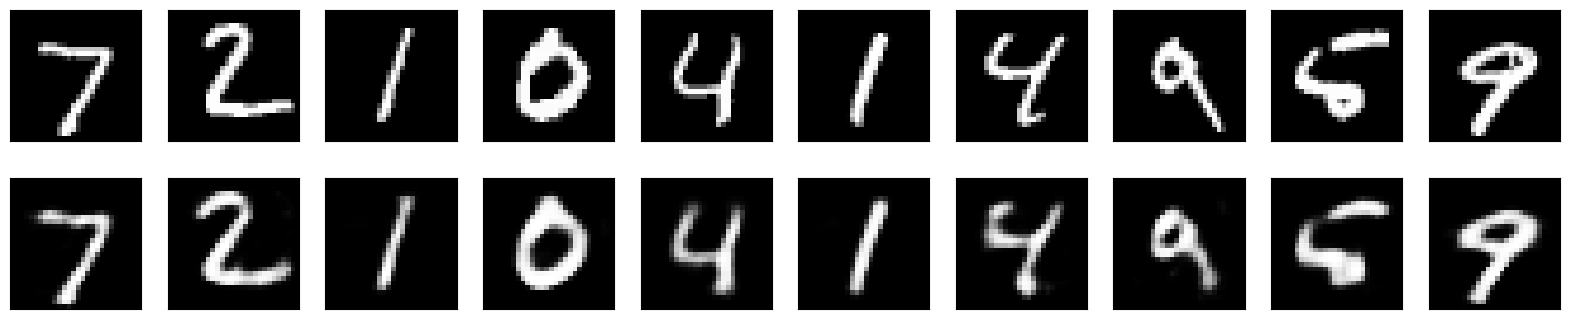

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
type(test_loader)

torch.utils.data.dataloader.DataLoader

# Using ReLu as activation function

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=64
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=64, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        out1 = self.encoder_hidden_layer(features)
        activation = torch.relu(out1)
        out2 = self.encoder_output_layer(activation)
        activation1 = torch.sigmoid(out2)
        out3 = self.decoder_hidden_layer(activation1)
        activation2 = torch.relu(out3)
        out4 = self.decoder_output_layer(activation2)
        reconstructed = torch.relu(out4)
        return reconstructed

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
loss =[]
for epoch in range(epochs):
    loss1 = []
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        #loss += train_loss.item()

        loss1.append(train_loss.detach())
        #print(loss1)
    
    loss.append(np.mean(loss1))
    # compute the epoch training loss
    #loss = loss / len(train_loader)
    
    # display the epoch training loss
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

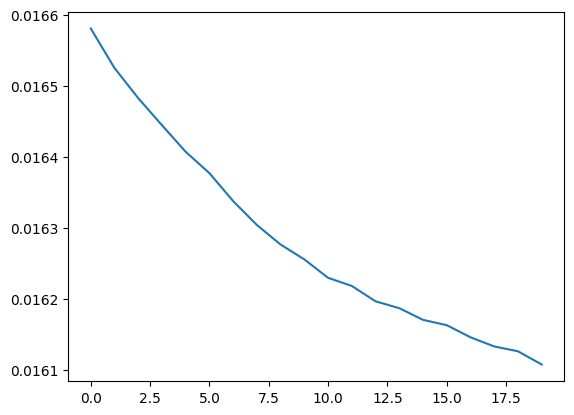

In [ ]:
plt.plot(loss)

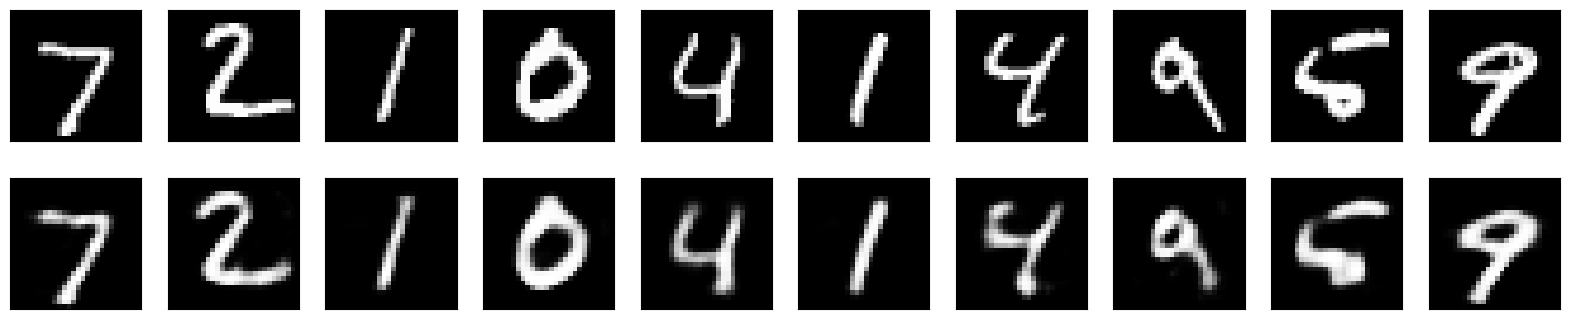

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Using sigmoid as activation function and BCELoss as metric

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=64
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=64, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        out1 = self.encoder_hidden_layer(features)
        activation = torch.relu(out1)
        out2 = self.encoder_output_layer(activation)
        activation1 = torch.sigmoid(out2)
        out3 = self.decoder_hidden_layer(activation1)
        activation2 = torch.relu(out3)
        out4 = self.decoder_output_layer(activation2)
        reconstructed = torch.sigmoid(out4)
        return reconstructed

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.BCELoss()

In [ ]:
loss =[]
for epoch in range(epochs):
    loss1 = []
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        #loss += train_loss.item()

        loss1.append(train_loss.detach())
        #print(loss1)
    
    loss.append(np.mean(loss1))
    # compute the epoch training loss
    #loss = loss / len(train_loader)
    
    # display the epoch training loss
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

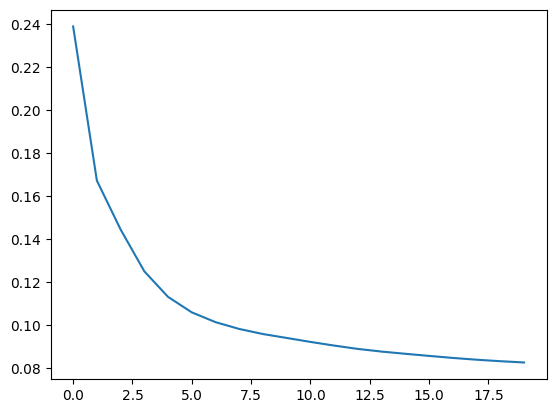

In [ ]:
plt.plot(loss)

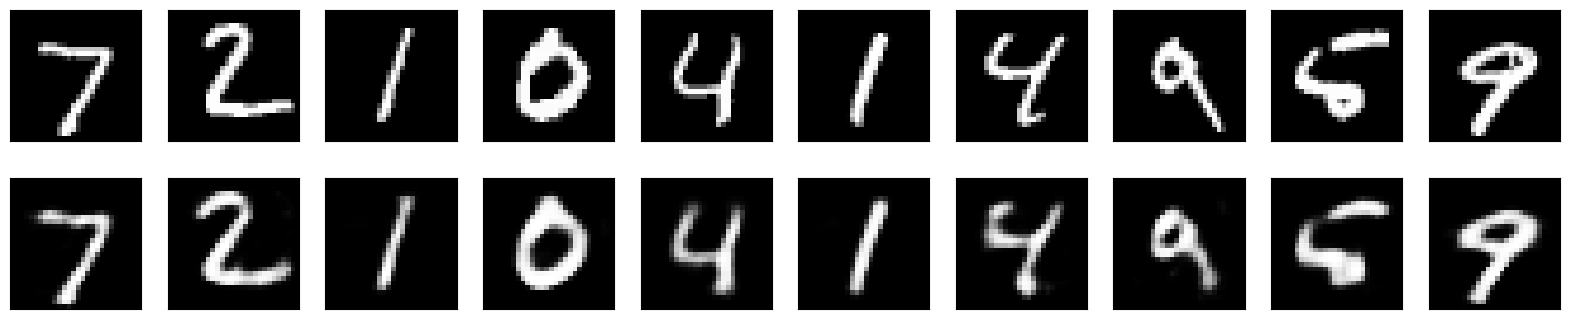

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Reduction of number of units in the hidden layers

In [12]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=8
        )
        self.encoder_output_layer = nn.Linear(
            in_features=8, out_features=4
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=4, out_features=8
        )
        self.decoder_output_layer = nn.Linear(
            in_features=8, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        out1 = self.encoder_hidden_layer(features)
        activation = torch.relu(out1)
        out2 = self.encoder_output_layer(activation)
        activation1 = torch.sigmoid(out2)
        out3 = self.decoder_hidden_layer(activation1)
        activation2 = torch.relu(out3)
        out4 = self.decoder_output_layer(activation2)
        reconstructed = torch.sigmoid(out4)
        return reconstructed

In [13]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.BCELoss()

In [14]:
loss =[]
for epoch in range(epochs):
    loss1 = []
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        #loss += train_loss.item()

        loss1.append(train_loss.detach())
        #print(loss1)
    
    loss.append(np.mean(loss1))
    # compute the epoch training loss
    #loss = loss / len(train_loader)
    
    # display the epoch training loss
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

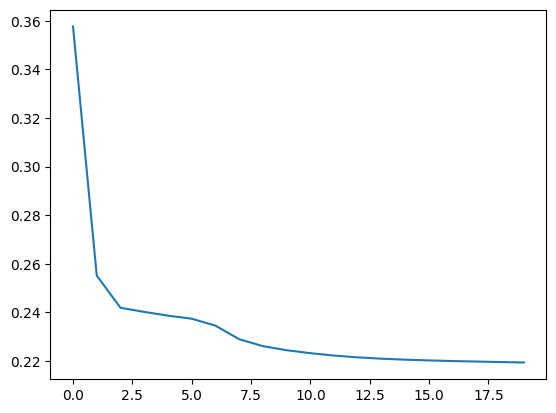

In [15]:
plt.plot(loss)

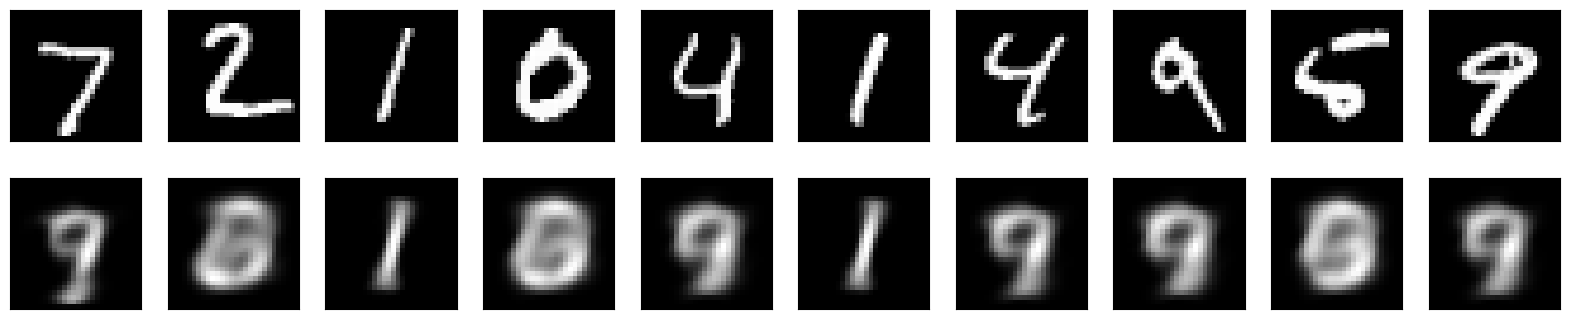

In [23]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()